In [1]:
import pandas as pd 
import json 
import matplotlib
from matplotlib import pyplot as plt 


In [2]:
from numpy import *
from matplotlib.pyplot import *

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.bf'] = 'DejaVu Sans:italic:bold'


In [3]:
from src.predict import calculate_raw_descriptors
from src.screening import *

In [4]:
raw_path = "csv/ChemBL_4to99.csv"
raw_df = pd.read_csv(raw_path, sep=";")
raw_df.rename({"Smiles": "h_smiles"}, axis=1, inplace=True)

In [5]:
skimmed_df = filter_metal(raw_df)
df = add_ch3_smiles(skimmed_df)
df, failed = filter_empty_ch3_smiles(df)

/Users/quachcd/Documents/science/imodels/iMoDELS-supplements/screening/src/screening.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ch3_smiles"] = ""
/Users/quachcd/Documents/science/imodels/iMoDELS-supplements/screening/src/screening.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ch3_smiles"][idx] = h_to_ch3_smiles(row["h_smiles"])


In [6]:
final_df = pd.DataFrame()
missingh_df = pd.DataFrame()
failed_df = pd.DataFrame()
for idx, row in df.iterrows():
    try:
        tmp_df = calculate_raw_descriptors(row['h_smiles'],
                                  row['ch3_smiles'],
                                  ind_descriptors="csv/descriptors-ind.csv")
        if all(tmp_df[row['ch3_smiles']].notna()):
            final_df = final_df.append(row)
        else:
            missingh_df = missingh_df.append(row)
    except:
        failed_df = failed_df.append(row)

O=CC(=O)O and O=C(C)C(=O)O already exist in ind_descriptors
Calculating chemical descriptors for O=C1C=CC(=O)O1 and O=C(C)1C=CC(=O)O1
CN.O=[N+]([O-])O and CCN.O=[N+]([O-])O already exist in ind_descriptors
CC(C)CC#N and CCC(C)CC#N already exist in ind_descriptors


RDKit ERROR: [17:11:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:43] Explicit valence for atom # 1 C, 5, is greater than permitted


OC/C=C/CO and C(O)C/C=C/CO already exist in ind_descriptors
C/N=C1\CCCN1 and CC/N=C1\CCCN1 already exist in ind_descriptors
Calculating chemical descriptors for N#CCCl and N#CCC(l)C
CCNCCO and CCCNCCO already exist in ind_descriptors


RDKit ERROR: [17:11:43] SMILES Parse Error: syntax error while parsing: N#CCC(l)C
[17:11:43] SMILES Parse Error: syntax error while parsing: N#CCC(l)C
RDKit ERROR: [17:11:43] SMILES Parse Error: Failed parsing SMILES 'N#CCC(l)C' for input: 'N#CCC(l)C'
[17:11:43] SMILES Parse Error: Failed parsing SMILES 'N#CCC(l)C' for input: 'N#CCC(l)C'


NC(=O)C1CO1 and C(N)C(=O)C1CO1 already exist in ind_descriptors
CN1C=CN(C)C1 and CCN1C=CN(C)C1 already exist in ind_descriptors
CC(CO)CO and CCC(CO)CO already exist in ind_descriptors
Calculating chemical descriptors for N.N.O=C(O)O and N.N.O=C(C)(O)O


RDKit ERROR: [17:11:43] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:11:43] Explicit valence for atom # 3 C, 5, is greater than permitted


COCCOC and CCOCCOC already exist in ind_descriptors
NC(N)=O.OO and C(N)C(N)=O.OO already exist in ind_descriptors
COCCl and CCOCCl already exist in ind_descriptors
C1CS1 and CC1CS1 already exist in ind_descriptors
COCC(C)O and CCOCC(C)O already exist in ind_descriptors
N#CCC(=O)O and N#CC(C)C(=O)O already exist in ind_descriptors
CC(=O)C(C)O and CCC(=O)C(C)O already exist in ind_descriptors
C=C(C)CNCC and CC=C(C)CNCC already exist in ind_descriptors
Calculating chemical descriptors for N[14C](N)=O and N[14C(C)](N)=O
CNC(=N)NC and CCNC(=N)NC already exist in ind_descriptors
C=CC(C)(C)C and CC=CC(C)(C)C already exist in ind_descriptors
COC(C)OC and CCOC(C)OC already exist in ind_descriptors


RDKit ERROR: [17:11:44] SMILES Parse Error: syntax error while parsing: N[14C(C)](N)=O
[17:11:44] SMILES Parse Error: syntax error while parsing: N[14C(C)](N)=O
RDKit ERROR: [17:11:44] SMILES Parse Error: Failed parsing SMILES 'N[14C(C)](N)=O' for input: 'N[14C(C)](N)=O'
[17:11:44] SMILES Parse Error: Failed parsing SMILES 'N[14C(C)](N)=O' for input: 'N[14C(C)](N)=O'


Calculating chemical descriptors for O=C1CN=CN1 and O=C(C)1CN=CN1
CN1CCCCC1 and CCN1CCCCC1 already exist in ind_descriptors
CCC(C)C=O and CCCC(C)C=O already exist in ind_descriptors
CCCO and CCCCO already exist in ind_descriptors


RDKit ERROR: [17:11:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:44] Explicit valence for atom # 1 C, 5, is greater than permitted


CN(C)C.O and CCN(C)C.O already exist in ind_descriptors
CCC(=O)[O-].[Na+] and CCCC(=O)[O-].[Na+] already exist in ind_descriptors
CC#N and CCC#N already exist in ind_descriptors
C1=CC2OC2C=C1 and CC1=CC2OC2C=C1 already exist in ind_descriptors
C[S+](C)C and CC[S+](C)C already exist in ind_descriptors
CNC(=O)NC and CCNC(=O)NC already exist in ind_descriptors
CC(C)(C)S and CCC(C)(C)S already exist in ind_descriptors
CCC(C)=O and CCCC(C)=O already exist in ind_descriptors
COCCC#N and CCOCCC#N already exist in ind_descriptors
N#CCCC#N and N#CC(C)CC#N already exist in ind_descriptors
CNC(N)=S and CCNC(N)=S already exist in ind_descriptors
Calculating chemical descriptors for O=CNC1CC1 and O=CNC1CC(1)C
C=CC(O)CC and CC=CC(O)CC already exist in ind_descriptors
CCCC(C)C and CCCCC(C)C already exist in ind_descriptors


RDKit ERROR: [17:11:45] SMILES Parse Error: syntax error while parsing: O=CNC1CC(1)C
[17:11:45] SMILES Parse Error: syntax error while parsing: O=CNC1CC(1)C
RDKit ERROR: [17:11:45] SMILES Parse Error: Failed parsing SMILES 'O=CNC1CC(1)C' for input: 'O=CNC1CC(1)C'
[17:11:45] SMILES Parse Error: Failed parsing SMILES 'O=CNC1CC(1)C' for input: 'O=CNC1CC(1)C'


O=CC=O and O=C(C)C=O already exist in ind_descriptors
CN1CCCC1 and CCN1CCCC1 already exist in ind_descriptors
C=CCNC and CC=CCNC already exist in ind_descriptors
C=CC(O)CC#N and CC=CC(O)CC#N already exist in ind_descriptors
C1CCSC1 and CC1CCSC1 already exist in ind_descriptors
C[N+](C)=CCl and CC[N+](C)=CCl already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)CCl and N=C(N)CC(l)C
CC(=O)C(C)C and CCC(=O)C(C)C already exist in ind_descriptors
CC#CC and CCC#CC already exist in ind_descriptors


RDKit ERROR: [17:11:45] SMILES Parse Error: syntax error while parsing: N=C(N)CC(l)C
[17:11:45] SMILES Parse Error: syntax error while parsing: N=C(N)CC(l)C
RDKit ERROR: [17:11:45] SMILES Parse Error: Failed parsing SMILES 'N=C(N)CC(l)C' for input: 'N=C(N)CC(l)C'
[17:11:45] SMILES Parse Error: Failed parsing SMILES 'N=C(N)CC(l)C' for input: 'N=C(N)CC(l)C'


CCCCS and CCCCCS already exist in ind_descriptors
CCB(O)O and CCCB(O)O already exist in ind_descriptors
N#CCN and N#CC(N)C already exist in ind_descriptors
CC(C)(N)C#N and CCC(C)(N)C#N already exist in ind_descriptors
CCN(O)CC and CCCN(O)CC already exist in ind_descriptors
C=CCNC(=N)N and CC=CCNC(=N)N already exist in ind_descriptors
C1COCO1 and CC1COCO1 already exist in ind_descriptors
Cc1cc[nH]c1 and CCc1cc[nH]c1 already exist in ind_descriptors
COC(=O)NN and CCOC(=O)NN already exist in ind_descriptors
Calculating chemical descriptors for C[P+](C)(C)C and CC[P+](C)(C)C
CNC and CCNC already exist in ind_descriptors
Calculating chemical descriptors for N[13C](N)=O and N[13C(C)](N)=O
CC(=O)CCl and CCC(=O)CCl already exist in ind_descriptors


RDKit ERROR: [17:11:46] UFFTYPER: Unrecognized charge state for atom: 1
[17:11:46] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [17:11:46] SMILES Parse Error: syntax error while parsing: N[13C(C)](N)=O
[17:11:46] SMILES Parse Error: syntax error while parsing: N[13C(C)](N)=O
RDKit ERROR: [17:11:46] SMILES Parse Error: Failed parsing SMILES 'N[13C(C)](N)=O' for input: 'N[13C(C)](N)=O'
[17:11:46] SMILES Parse Error: Failed parsing SMILES 'N[13C(C)](N)=O' for input: 'N[13C(C)](N)=O'


NCc1nnn[nH]1 and C(N)Cc1nnn[nH]1 already exist in ind_descriptors
O=CNNC=O and O=C(C)NNC=O already exist in ind_descriptors
CC(C)C(N)=O and CCC(C)C(N)=O already exist in ind_descriptors
CC[N+](=O)[O-] and CCC[N+](=O)[O-] already exist in ind_descriptors
CC(O)CCO and CCC(O)CCO already exist in ind_descriptors
C#CCNCC and CC#CCNCC already exist in ind_descriptors
O=C(O)CCO and O=C(O)CC(O)C already exist in ind_descriptors
CC=CCC#N and CCC=CCC#N already exist in ind_descriptors
C/C=C/C=C/CO and CC/C=C/C=C/CO already exist in ind_descriptors
COC(=O)OC and CCOC(=O)OC already exist in ind_descriptors
C#CCNC and CC#CCNC already exist in ind_descriptors
C=CCON and CC=CCON already exist in ind_descriptors
OCCF and C(O)CCF already exist in ind_descriptors
CNC=O and CCNC=O already exist in ind_descriptors
OC1CCNC1 and C(O)C1CCNC1 already exist in ind_descriptors
CN(C)CC#N and CCN(C)CC#N already exist in ind_descriptors
CCC and CCCC already exist in ind_descriptors
CCCC(=O)O and CCCCC(=O)O already

RDKit ERROR: [17:11:47] SMILES Parse Error: syntax error while parsing: [Na+].[O-][C(C)l+][O-]
[17:11:47] SMILES Parse Error: syntax error while parsing: [Na+].[O-][C(C)l+][O-]
RDKit ERROR: [17:11:47] SMILES Parse Error: Failed parsing SMILES '[Na+].[O-][C(C)l+][O-]' for input: '[Na+].[O-][C(C)l+][O-]'
[17:11:47] SMILES Parse Error: Failed parsing SMILES '[Na+].[O-][C(C)l+][O-]' for input: '[Na+].[O-][C(C)l+][O-]'


C/C=C(\C)C=O and CC/C=C(\C)C=O already exist in ind_descriptors
CCNCCN and CCCNCCN already exist in ind_descriptors
O=C(O)CS and O=C(O)C(S)C already exist in ind_descriptors
O=[N+]([O-])CCO and O=[N+]([O-])CC(O)C already exist in ind_descriptors
Cc1ccc(C)[nH]1 and CCc1ccc(C)[nH]1 already exist in ind_descriptors
CCC(C)C and CCCC(C)C already exist in ind_descriptors
Nc1ccccc1 and C(N)c1ccccc1 already exist in ind_descriptors
Calculating chemical descriptors for [2H]C([2H])([2H])NC=O and [2H]C(C)([2H])([2H])NC=O
Calculating chemical descriptors for O=C(O)CCl and O=C(O)CC(l)C
CC(C)(C)Cl and CCC(C)(C)Cl already exist in ind_descriptors


RDKit ERROR: [17:11:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:48] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:48] SMILES Parse Error: syntax error while parsing: O=C(O)CC(l)C
[17:11:48] SMILES Parse Error: syntax error while parsing: O=C(O)CC(l)C
RDKit ERROR: [17:11:48] SMILES Parse Error: Failed parsing SMILES 'O=C(O)CC(l)C' for input: 'O=C(O)CC(l)C'
[17:11:48] SMILES Parse Error: Failed parsing SMILES 'O=C(O)CC(l)C' for input: 'O=C(O)CC(l)C'
RDKit ERROR: [17:11:48] SMILES Parse Error: syntax error while parsing: O=CC1CCCC(1)C
[17:11:48] SMILES Parse Error: syntax error while parsing: O=CC1CCCC(1)C
RDKit ERROR: [17:11:48] SMILES Parse Error: Failed parsing SMILES 'O=CC1CCCC(1)C' for input: 'O=CC1CCCC(1)C'
[17:11:48] SMILES Parse Error: Failed parsing SMILES 'O=CC1CCCC(1)C' for input: 'O=CC1CCCC(1)C'


Calculating chemical descriptors for O=CC1CCCC1 and O=CC1CCCC(1)C
CC/C=C\CO and CCC/C=C\CO already exist in ind_descriptors
C1CSCN1 and CC1CSCN1 already exist in ind_descriptors
C1CCOC1 and CC1CCOC1 already exist in ind_descriptors
CN and CCN already exist in ind_descriptors
C[C@H](O)C(=O)O and CC[C@H](O)C(=O)O already exist in ind_descriptors
CC(C)(N)CO and CCC(C)(N)CO already exist in ind_descriptors
CCCCl and CCCCCl already exist in ind_descriptors
Calculating chemical descriptors for N#CCCCl and N#CCCC(l)C


RDKit ERROR: [17:11:48] SMILES Parse Error: syntax error while parsing: N#CCCC(l)C
[17:11:48] SMILES Parse Error: syntax error while parsing: N#CCCC(l)C
RDKit ERROR: [17:11:48] SMILES Parse Error: Failed parsing SMILES 'N#CCCC(l)C' for input: 'N#CCCC(l)C'
[17:11:48] SMILES Parse Error: Failed parsing SMILES 'N#CCCC(l)C' for input: 'N#CCCC(l)C'
RDKit ERROR: [17:11:49] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:11:49] Explicit valence for atom # 1 Cl, 2, is greater than permitted


OCCCCF and C(O)CCCCF already exist in ind_descriptors
C[C@H](O)CCO and CC[C@H](O)CCO already exist in ind_descriptors
Calculating chemical descriptors for ClCCCl and CClCCCl
O=C[O-].[Na+] and O=C(C)[O-].[Na+] already exist in ind_descriptors
Calculating chemical descriptors for O=C1NCCO1 and O=C(C)1NCCO1


RDKit ERROR: [17:11:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:49] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:49] SMILES Parse Error: syntax error while parsing: C([)C-]#N.[Na+]
[17:11:49] SMILES Parse Error: syntax error while parsing: C([)C-]#N.[Na+]
RDKit ERROR: [17:11:49] SMILES Parse Error: Failed parsing SMILES 'C([)C-]#N.[Na+]' for input: 'C([)C-]#N.[Na+]'
[17:11:49] SMILES Parse Error: Failed parsing SMILES 'C([)C-]#N.[Na+]' for input: 'C([)C-]#N.[Na+]'


CCCN=C=O and CCCCN=C=O already exist in ind_descriptors
CC1CCNC1=O and CCC1CCNC1=O already exist in ind_descriptors
Calculating chemical descriptors for [C-]#N.[Na+] and C([)C-]#N.[Na+]
C=CCN=C=S and CC=CCN=C=S already exist in ind_descriptors
CC(C)C=O and CCC(C)C=O already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)NN=O and N=C(C)(N)NN=O
CC(=N)S and CCC(=N)S already exist in ind_descriptors
O=C(O)CF and O=C(O)C(F)C already exist in ind_descriptors
CC1CCCNC1 and CCC1CCCNC1 already exist in ind_descriptors


RDKit ERROR: [17:11:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:49] Explicit valence for atom # 1 C, 5, is greater than permitted


C=C(C)C(=O)O and CC=C(C)C(=O)O already exist in ind_descriptors
CC1CN=C(N)C1 and CCC1CN=C(N)C1 already exist in ind_descriptors
CSCCO and CCSCCO already exist in ind_descriptors
OCCNCO and C(O)CCNCO already exist in ind_descriptors
CP(=O)(O)O and CCP(=O)(O)O already exist in ind_descriptors
CC1CC(=O)O1 and CCC1CC(=O)O1 already exist in ind_descriptors
NC(CO)CO and C(N)C(CO)CO already exist in ind_descriptors
C=CNC#N and CC=CNC#N already exist in ind_descriptors
CSSC and CCSSC already exist in ind_descriptors
C[N+](C)(C)C.[OH-] and CC[N+](C)(C)C.[OH-] already exist in ind_descriptors
Calculating chemical descriptors for O=C1C=CCC1 and O=C1C=CCC(1)C
C=CCC and CC=CCC already exist in ind_descriptors
Calculating chemical descriptors for [C-]#[N+][O-] and C([)C-]#[N+][O-]


RDKit ERROR: [17:11:50] SMILES Parse Error: syntax error while parsing: O=C1C=CCC(1)C
[17:11:50] SMILES Parse Error: syntax error while parsing: O=C1C=CCC(1)C
RDKit ERROR: [17:11:50] SMILES Parse Error: Failed parsing SMILES 'O=C1C=CCC(1)C' for input: 'O=C1C=CCC(1)C'
[17:11:50] SMILES Parse Error: Failed parsing SMILES 'O=C1C=CCC(1)C' for input: 'O=C1C=CCC(1)C'


CC(C)NO and CCC(C)NO already exist in ind_descriptors
CC[C@@H](N)CO and CCC[C@@H](N)CO already exist in ind_descriptors
C#C and CC#C already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)NO and N=C(C)(N)NO


RDKit ERROR: [17:11:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:50] Explicit valence for atom # 1 C, 5, is greater than permitted


NC1C=NNC1=O and C(N)C1C=NNC1=O already exist in ind_descriptors
CN(CC#N)N=O and CCN(CC#N)N=O already exist in ind_descriptors
NCC=O and C(N)CC=O already exist in ind_descriptors
CCC=C=CCN and CCCC=C=CCN already exist in ind_descriptors
Calculating chemical descriptors for NNC(=O)NO and NNC(C)(=O)NO
CC(C)NC=O and CCC(C)NC=O already exist in ind_descriptors
CCC=O and CCCC=O already exist in ind_descriptors
NNCCO and NNCC(O)C already exist in ind_descriptors


RDKit ERROR: [17:11:50] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:11:50] Explicit valence for atom # 2 C, 5, is greater than permitted


Calculating chemical descriptors for N.NC(=O)O and N.NC(C)(=O)O
Calculating chemical descriptors for O=C(O)C(F)F and O=C(C)(O)C(F)F
CCNC and CCCNC already exist in ind_descriptors
C/C=C\CO and CC/C=C\CO already exist in ind_descriptors


RDKit ERROR: [17:11:51] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:11:51] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [17:11:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:51] Explicit valence for atom # 1 C, 5, is greater than permitted


COC(=O)Cl and CCOC(=O)Cl already exist in ind_descriptors
CCNN and CCCNN already exist in ind_descriptors
CNCCCN and CCNCCCN already exist in ind_descriptors
CC(C)C(=O)O and CCC(C)C(=O)O already exist in ind_descriptors
OCC#CCO and C(O)CC#CCO already exist in ind_descriptors
OCCCCO and C(O)CCCCO already exist in ind_descriptors
Cc1ccc(C)o1 and CCc1ccc(C)o1 already exist in ind_descriptors
CCC1CO1 and CCCC1CO1 already exist in ind_descriptors
Cl.NO and CCl.NO already exist in ind_descriptors
CC(C)CO and CCC(C)CO already exist in ind_descriptors
Calculating chemical descriptors for O=C(O)CNO and O=C(C)(O)CNO
Calculating chemical descriptors for [C-]#[N+]C#CCCN and C([)C-]#[N+]C#CCCN


RDKit ERROR: [17:11:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:51] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:51] SMILES Parse Error: syntax error while parsing: C([)C-]#[N+]C#CCCN
[17:11:51] SMILES Parse Error: syntax error while parsing: C([)C-]#[N+]C#CCCN
RDKit ERROR: [17:11:51] SMILES Parse Error: Failed parsing SMILES 'C([)C-]#[N+]C#CCCN' for input: 'C([)C-]#[N+]C#CCCN'
[17:11:51] SMILES Parse Error: Failed parsing SMILES 'C([)C-]#[N+]C#CCCN' for input: 'C([)C-]#[N+]C#CCCN'


CC(N)Cl and CCC(N)Cl already exist in ind_descriptors
CC1CCCC1 and CCC1CCCC1 already exist in ind_descriptors
C=CC(=O)NC and CC=CC(=O)NC already exist in ind_descriptors
C1CCCC1 and CC1CCCC1 already exist in ind_descriptors
C#[N+][O-] and CC#[N+][O-] already exist in ind_descriptors
CCN and CCCN already exist in ind_descriptors
CCC(N)CO and CCCC(N)CO already exist in ind_descriptors
CCCCN=C=O and CCCCCN=C=O already exist in ind_descriptors
CC(C)CCl and CCC(C)CCl already exist in ind_descriptors
C1CCCCC1 and CC1CCCCC1 already exist in ind_descriptors
CCN(C)N=O and CCCN(C)N=O already exist in ind_descriptors
Calculating chemical descriptors for O=C1CCCN1 and O=C(C)1CCCN1


RDKit ERROR: [17:11:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:52] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:52] Explicit valence for atom # 1 C, 5, is greater than permitted


CSC(=N)N and CCSC(=N)N already exist in ind_descriptors
C=C[C@@H](O)CC#N and CC=C[C@@H](O)CC#N already exist in ind_descriptors
Calculating chemical descriptors for N=C(NN)NO and N=C(C)(NN)NO
CC1CCNCC1 and CCC1CCNCC1 already exist in ind_descriptors
C=CC(=O)O and CC=CC(=O)O already exist in ind_descriptors
C#CC and CC#CC already exist in ind_descriptors
COC(=O)CN and CCOC(=O)CN already exist in ind_descriptors
CN1C=CNC1N and CCN1C=CNC1N already exist in ind_descriptors
C#CC(=O)O and CC#CC(=O)O already exist in ind_descriptors
CC(=O)OO and CCC(=O)OO already exist in ind_descriptors
Calculating chemical descriptors for O=CC1CCC1 and O=CC1CCC(1)C
CN(C)C=S and CCN(C)C=S already exist in ind_descriptors


RDKit ERROR: [17:11:53] SMILES Parse Error: syntax error while parsing: O=CC1CCC(1)C
[17:11:53] SMILES Parse Error: syntax error while parsing: O=CC1CCC(1)C
RDKit ERROR: [17:11:53] SMILES Parse Error: Failed parsing SMILES 'O=CC1CCC(1)C' for input: 'O=CC1CCC(1)C'
[17:11:53] SMILES Parse Error: Failed parsing SMILES 'O=CC1CCC(1)C' for input: 'O=CC1CCC(1)C'


CC(C)S and CCC(C)S already exist in ind_descriptors
N#C/C=C/C#N and N#C/C(C)=C/C#N already exist in ind_descriptors
CCC1OC1C and CCCC1OC1C already exist in ind_descriptors
CC(C)C and CCC(C)C already exist in ind_descriptors
CCSCC and CCCSCC already exist in ind_descriptors
CCCC(N)=O and CCCCC(N)=O already exist in ind_descriptors
C=CCCC and CC=CCCC already exist in ind_descriptors
NCN and C(N)CN already exist in ind_descriptors
C1=CCC2OC2C1 and CC1=CCC2OC2C1 already exist in ind_descriptors
C=NO and CC=NO already exist in ind_descriptors
C=CCl and CC=CCl already exist in ind_descriptors
CC/C=C/C=O and CCC/C=C/C=O already exist in ind_descriptors
CN(C)C=[N+]=[N-] and CCN(C)C=[N+]=[N-] already exist in ind_descriptors
CC(=O)NN and CCC(=O)NN already exist in ind_descriptors
CCC(C)CN and CCCC(C)CN already exist in ind_descriptors
CC1=CCC(=O)O1 and CCC1=CCC(=O)O1 already exist in ind_descriptors
N#CC1CN1 and N#CC(C)1CN1 already exist in ind_descriptors
Calculating chemical descriptors for O

RDKit ERROR: [17:11:54] SMILES Parse Error: syntax error while parsing: O=NN1CC=CC(1)C
[17:11:54] SMILES Parse Error: syntax error while parsing: O=NN1CC=CC(1)C
RDKit ERROR: [17:11:54] SMILES Parse Error: Failed parsing SMILES 'O=NN1CC=CC(1)C' for input: 'O=NN1CC=CC(1)C'
[17:11:54] SMILES Parse Error: Failed parsing SMILES 'O=NN1CC=CC(1)C' for input: 'O=NN1CC=CC(1)C'


CCOC(N)=O and CCCOC(N)=O already exist in ind_descriptors
O=Cc1ccc[nH]1 and O=C(C)c1ccc[nH]1 already exist in ind_descriptors
Calculating chemical descriptors for O=C1NCCN1 and O=C(C)1NCCN1
CCl and CCCl already exist in ind_descriptors


RDKit ERROR: [17:11:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:54] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:54] Explicit valence for atom # 1 C, 5, is greater than permitted


NCCCl and C(N)CCCl already exist in ind_descriptors
Calculating chemical descriptors for O=C1OCCO1 and O=C(C)1OCCO1
C1CCNC1 and CC1CCNC1 already exist in ind_descriptors
OCCC(F)F and C(O)CCC(F)F already exist in ind_descriptors
CN1CC=CC1=O and CCN1CC=CC1=O already exist in ind_descriptors
CON(C)N=O and CCON(C)N=O already exist in ind_descriptors
C=C(C)C#N and CC=C(C)C#N already exist in ind_descriptors
Calculating chemical descriptors for O=C(O)[C@@H]1CN1 and O=C(C)(O)[C@@H]1CN1


RDKit ERROR: [17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted


Cc1cc[nH]n1 and CCc1cc[nH]n1 already exist in ind_descriptors
NCC(=O)CN and C(N)CC(=O)CN already exist in ind_descriptors
CN(C)C=O and CCN(C)C=O already exist in ind_descriptors
OC1CCOC1 and C(O)C1CCOC1 already exist in ind_descriptors
C/C=C/C=O and CC/C=C/C=O already exist in ind_descriptors
CNO and CCNO already exist in ind_descriptors
Calculating chemical descriptors for N#CO and N#C(O)C
CC(C)N(C)C and CCC(C)N(C)C already exist in ind_descriptors


RDKit ERROR: [17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted


C=CCCCC and CC=CCCCC already exist in ind_descriptors
Calculating chemical descriptors for O=C1C=CCO1 and O=C(C)1C=CCO1
C1NC2CNC1N2 and CC1NC2CNC1N2 already exist in ind_descriptors
C/C=C/C(=O)NC and CC/C=C/C(=O)NC already exist in ind_descriptors
Nc1n[nH]c(N)n1 and C(N)c1n[nH]c(N)n1 already exist in ind_descriptors
N#[N+]C1N=CC[N-]1 and N#[N+]C(C)1N=CC[N-]1 already exist in ind_descriptors
Calculating chemical descriptors for O=C1C=CC(=O)N1 and O=C(C)1C=CC(=O)N1
Calculating chemical descriptors for ClC=CCl and CClC=CCl


RDKit ERROR: [17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:55] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:55] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:11:55] Explicit valence for atom # 1 Cl, 2, is greater than permitted


C#CC=O and CC#CC=O already exist in ind_descriptors
C1CCCNCC1 and CC1CCCNCC1 already exist in ind_descriptors
FC1NC=CN1 and C(F)C1NC=CN1 already exist in ind_descriptors
C[C@H]1CC(=O)O1 and CC[C@H]1CC(=O)O1 already exist in ind_descriptors
Calculating chemical descriptors for O=C1CCCCC1 and O=C1CCCCC(1)C
NCC(=O)S and C(N)CC(=O)S already exist in ind_descriptors
NC(N)=S and C(N)C(N)=S already exist in ind_descriptors
C/C=C/C(N)=O and CC/C=C/C(N)=O already exist in ind_descriptors


RDKit ERROR: [17:11:56] SMILES Parse Error: syntax error while parsing: O=C1CCCCC(1)C
[17:11:56] SMILES Parse Error: syntax error while parsing: O=C1CCCCC(1)C
RDKit ERROR: [17:11:56] SMILES Parse Error: Failed parsing SMILES 'O=C1CCCCC(1)C' for input: 'O=C1CCCCC(1)C'
[17:11:56] SMILES Parse Error: Failed parsing SMILES 'O=C1CCCCC(1)C' for input: 'O=C1CCCCC(1)C'


CS(=O)(=O)F and CCS(=O)(=O)F already exist in ind_descriptors
Calculating chemical descriptors for O=CCCl and O=CCC(l)C
CC/C=C\C#N and CCC/C=C\C#N already exist in ind_descriptors
CNNC and CCNNC already exist in ind_descriptors


RDKit ERROR: [17:11:56] SMILES Parse Error: syntax error while parsing: O=CCC(l)C
[17:11:56] SMILES Parse Error: syntax error while parsing: O=CCC(l)C
RDKit ERROR: [17:11:56] SMILES Parse Error: Failed parsing SMILES 'O=CCC(l)C' for input: 'O=CCC(l)C'
[17:11:56] SMILES Parse Error: Failed parsing SMILES 'O=CCC(l)C' for input: 'O=CCC(l)C'


CCC(N)=O and CCCC(N)=O already exist in ind_descriptors
Calculating chemical descriptors for N#CC(=O)C#N and N#CC(C)(=O)C#N
NCCCP and C(N)CCCP already exist in ind_descriptors
CC1NC=CN1 and CCC1NC=CN1 already exist in ind_descriptors
CCCCC=O and CCCCCC=O already exist in ind_descriptors


RDKit ERROR: [17:11:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:11:56] Explicit valence for atom # 2 C, 5, is greater than permitted


Calculating chemical descriptors for O=C1CNCN1 and O=C(C)1CNCN1
CCNNCC and CCCNNCC already exist in ind_descriptors
C1CO1 and CC1CO1 already exist in ind_descriptors
Calculating chemical descriptors for [22Na+].[Cl-] and [22Na+].[C(C)l-]


RDKit ERROR: [17:11:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:56] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:11:57] SMILES Parse Error: syntax error while parsing: [22Na+].[C(C)l-]
[17:11:57] SMILES Parse Error: syntax error while parsing: [22Na+].[C(C)l-]
RDKit ERROR: [17:11:57] SMILES Parse Error: Failed parsing SMILES '[22Na+].[C(C)l-]' for input: '[22Na+].[C(C)l-]'
[17:11:57] SMILES Parse Error: Failed parsing SMILES '[22Na+].[C(C)l-]' for input: '[22Na+].[C(C)l-]'


Calculating chemical descriptors for ON=C1CCCC1 and ON=C1CCCC(1)C
Calculating chemical descriptors for BC#N.CN(C)C and BC#N.CN(C)Cc
CBr and CCBr already exist in ind_descriptors
CC1CN1 and CCC1CN1 already exist in ind_descriptors


RDKit ERROR: [17:11:57] SMILES Parse Error: syntax error while parsing: ON=C1CCCC(1)C
[17:11:57] SMILES Parse Error: syntax error while parsing: ON=C1CCCC(1)C
RDKit ERROR: [17:11:57] SMILES Parse Error: Failed parsing SMILES 'ON=C1CCCC(1)C' for input: 'ON=C1CCCC(1)C'
[17:11:57] SMILES Parse Error: Failed parsing SMILES 'ON=C1CCCC(1)C' for input: 'ON=C1CCCC(1)C'
RDKit ERROR: [17:11:57] non-ring atom 7 marked aromatic
[17:11:57] non-ring atom 7 marked aromatic


CCC(O)CC and CCCC(O)CC already exist in ind_descriptors
NCB(O)O and C(N)CB(O)O already exist in ind_descriptors
C1=CCC=C1 and CC1=CCC=C1 already exist in ind_descriptors
Calculating chemical descriptors for O=C(O)C1C=C1 and O=C(O)C1C=C(1)C


RDKit ERROR: [17:11:57] SMILES Parse Error: syntax error while parsing: O=C(O)C1C=C(1)C
[17:11:57] SMILES Parse Error: syntax error while parsing: O=C(O)C1C=C(1)C
RDKit ERROR: [17:11:57] SMILES Parse Error: Failed parsing SMILES 'O=C(O)C1C=C(1)C' for input: 'O=C(O)C1C=C(1)C'
[17:11:57] SMILES Parse Error: Failed parsing SMILES 'O=C(O)C1C=C(1)C' for input: 'O=C(O)C1C=C(1)C'


CC(C)(C)NO and CCC(C)(C)NO already exist in ind_descriptors
CC=CC(=O)O and CCC=CC(=O)O already exist in ind_descriptors
CCCC=O and CCCCC=O already exist in ind_descriptors
OCC1CO1 and C(O)CC1CO1 already exist in ind_descriptors
Calculating chemical descriptors for O=C1C=C(O)CN1 and O=C(C)1C=C(O)CN1
C1COCCO1 and CC1COCCO1 already exist in ind_descriptors
CC1CCCO1 and CCC1CCCO1 already exist in ind_descriptors
Cc1nnn[nH]1 and CCc1nnn[nH]1 already exist in ind_descriptors


RDKit ERROR: [17:11:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:11:57] Explicit valence for atom # 1 C, 5, is greater than permitted


NC(=O)O and C(N)C(=O)O already exist in ind_descriptors
CC(C)CCN and CCC(C)CCN already exist in ind_descriptors
Calculating chemical descriptors for ClCC1CO1 and CClCC1CO1
CC(O)CCl and CCC(O)CCl already exist in ind_descriptors


RDKit ERROR: [17:11:58] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:11:58] Explicit valence for atom # 1 Cl, 2, is greater than permitted


C[N+](C)(C)C and CC[N+](C)(C)C already exist in ind_descriptors
CCC(C)=NO and CCCC(C)=NO already exist in ind_descriptors
NCCC(N)=O and C(N)CCC(N)=O already exist in ind_descriptors
C[11C](=O)[O-].[Na+] and CC[11C](=O)[O-].[Na+] already exist in ind_descriptors
O=Cc1c[nH]nn1 and O=C(C)c1c[nH]nn1 already exist in ind_descriptors
Calculating chemical descriptors for N#C[C@@H]1CCCN1 and N#C[C(C)@@H]1CCCN1
CC(C)OC=O and CCC(C)OC=O already exist in ind_descriptors
N#CCNCC#N and N#CC(C)NCC#N already exist in ind_descriptors


RDKit ERROR: [17:11:58] SMILES Parse Error: syntax error while parsing: N#C[C(C)@@H]1CCCN1
[17:11:58] SMILES Parse Error: syntax error while parsing: N#C[C(C)@@H]1CCCN1
RDKit ERROR: [17:11:58] SMILES Parse Error: Failed parsing SMILES 'N#C[C(C)@@H]1CCCN1' for input: 'N#C[C(C)@@H]1CCCN1'
[17:11:58] SMILES Parse Error: Failed parsing SMILES 'N#C[C(C)@@H]1CCCN1' for input: 'N#C[C(C)@@H]1CCCN1'


C=C(C)CCO and CC=C(C)CCO already exist in ind_descriptors
C=CCS and CC=CCS already exist in ind_descriptors
C=COC=C and CC=COC=C already exist in ind_descriptors
CCC/C=C/C=O and CCCC/C=C/C=O already exist in ind_descriptors
CC[S+](C)[O-] and CCC[S+](C)[O-] already exist in ind_descriptors
CC(C)(O)C#N and CCC(C)(O)C#N already exist in ind_descriptors
Calculating chemical descriptors for N#CN1CCC1 and N#CN1CCC(1)C
CC1=CC(=O)CC1 and CCC1=CC(=O)CC1 already exist in ind_descriptors


RDKit ERROR: [17:11:59] SMILES Parse Error: syntax error while parsing: N#CN1CCC(1)C
[17:11:59] SMILES Parse Error: syntax error while parsing: N#CN1CCC(1)C
RDKit ERROR: [17:11:59] SMILES Parse Error: Failed parsing SMILES 'N#CN1CCC(1)C' for input: 'N#CN1CCC(1)C'
[17:11:59] SMILES Parse Error: Failed parsing SMILES 'N#CN1CCC(1)C' for input: 'N#CN1CCC(1)C'


CC#CCN and CCC#CCN already exist in ind_descriptors
C#CCOC and CC#CCOC already exist in ind_descriptors
CCC=CC#N and CCCC=CC#N already exist in ind_descriptors
C=CC/C=C/C and CC=CC/C=C/C already exist in ind_descriptors
Calculating chemical descriptors for N[C@@H]1COC1=O and N[C(C)@@H]1COC1=O


RDKit ERROR: [17:11:59] SMILES Parse Error: syntax error while parsing: N[C(C)@@H]1COC1=O
[17:11:59] SMILES Parse Error: syntax error while parsing: N[C(C)@@H]1COC1=O
RDKit ERROR: [17:11:59] SMILES Parse Error: Failed parsing SMILES 'N[C(C)@@H]1COC1=O' for input: 'N[C(C)@@H]1COC1=O'
[17:11:59] SMILES Parse Error: Failed parsing SMILES 'N[C(C)@@H]1COC1=O' for input: 'N[C(C)@@H]1COC1=O'


CNC(N)NC and CCNC(N)NC already exist in ind_descriptors
N#CCC#N and N#CC(C)C#N already exist in ind_descriptors
CCCCNN and CCCCCNN already exist in ind_descriptors
Calculating chemical descriptors for [O-][Cl+]O and [O-][C(C)l+]O


RDKit ERROR: [17:11:59] SMILES Parse Error: syntax error while parsing: [O-][C(C)l+]O
[17:11:59] SMILES Parse Error: syntax error while parsing: [O-][C(C)l+]O
RDKit ERROR: [17:11:59] SMILES Parse Error: Failed parsing SMILES '[O-][C(C)l+]O' for input: '[O-][C(C)l+]O'
[17:11:59] SMILES Parse Error: Failed parsing SMILES '[O-][C(C)l+]O' for input: '[O-][C(C)l+]O'


C1CNC1 and CC1CNC1 already exist in ind_descriptors
C[S+](C)(C)=O and CC[S+](C)(C)=O already exist in ind_descriptors
CC(F)F and CCC(F)F already exist in ind_descriptors
Calculating chemical descriptors for [11C-]#[O+] and [11C(C)-]#[O+]
CCCC(C)=O and CCCCC(C)=O already exist in ind_descriptors
CN[N+](=O)[O-] and CCN[N+](=O)[O-] already exist in ind_descriptors
C=C(C=O)CC and CC=C(C=O)CC already exist in ind_descriptors
N.O=CO and N.O=C(O)C already exist in ind_descriptors
P and CP already exist in ind_descriptors
CC(N)CN and CCC(N)CN already exist in ind_descriptors
C=CC(=O)CCC and CC=CC(=O)CCC already exist in ind_descriptors
C=CC=O and CC=CC=O already exist in ind_descriptors
C=C(C)C(N)=O and CC=C(C)C(N)=O already exist in ind_descriptors
NC(=O)C1CC1 and C(N)C(=O)C1CC1 already exist in ind_descriptors
Calculating chemical descriptors for [C-]#[N+][O-].[Na+] and C([)C-]#[N+][O-].[Na+]
O=CC(O)CO and O=CC(O)C(O)C already exist in ind_descriptors
CCC(C)Cl and CCCC(C)Cl already exist in 

RDKit ERROR: [17:12:00] SMILES Parse Error: syntax error while parsing: C([)C-]#[N+][O-].[Na+]
[17:12:00] SMILES Parse Error: syntax error while parsing: C([)C-]#[N+][O-].[Na+]
RDKit ERROR: [17:12:00] SMILES Parse Error: Failed parsing SMILES 'C([)C-]#[N+][O-].[Na+]' for input: 'C([)C-]#[N+][O-].[Na+]'
[17:12:00] SMILES Parse Error: Failed parsing SMILES 'C([)C-]#[N+][O-].[Na+]' for input: 'C([)C-]#[N+][O-].[Na+]'


OCCN1CC1 and C(O)CCN1CC1 already exist in ind_descriptors
CCC(F)CO and CCCC(F)CO already exist in ind_descriptors
Calculating chemical descriptors for C[N+]#N and CC[N+]#N
Oc1nc[nH]n1 and C(O)c1nc[nH]n1 already exist in ind_descriptors
C[Si](C)=O and CC[Si](C)=O already exist in ind_descriptors
ON=CC=NO and ON=C(C)C=NO already exist in ind_descriptors
Nc1ncc[nH]1 and C(N)c1ncc[nH]1 already exist in ind_descriptors
N=C(N)CS and N=C(N)C(S)C already exist in ind_descriptors
CC(=O)NC#N and CCC(=O)NC#N already exist in ind_descriptors
CCC(=O)CC and CCCC(=O)CC already exist in ind_descriptors
CC1=CC1C(=O)O and CCC1=CC1C(=O)O already exist in ind_descriptors
CCNC=O and CCCNC=O already exist in ind_descriptors
CNC.Cl and CCNC.Cl already exist in ind_descriptors
C[n+]1ccccc1 and CC[n+]1ccccc1 already exist in ind_descriptors
C/C=C(C)/C=N/O and CC/C=C(C)/C=N/O already exist in ind_descriptors
NC1NC=CN1 and C(N)C1NC=CN1 already exist in ind_descriptors
Calculating chemical descriptors for [11CH3]

RDKit ERROR: [17:12:01] SMILES Parse Error: syntax error while parsing: [11C(C)H3]SC(=N)N
[17:12:01] SMILES Parse Error: syntax error while parsing: [11C(C)H3]SC(=N)N
RDKit ERROR: [17:12:01] SMILES Parse Error: Failed parsing SMILES '[11C(C)H3]SC(=N)N' for input: '[11C(C)H3]SC(=N)N'
[17:12:01] SMILES Parse Error: Failed parsing SMILES '[11C(C)H3]SC(=N)N' for input: '[11C(C)H3]SC(=N)N'


C=C1CCOC1=O and CC=C1CCOC1=O already exist in ind_descriptors
CS(C)(=O)=O and CCS(C)(=O)=O already exist in ind_descriptors
CSC and CCSC already exist in ind_descriptors
NC1=NC(=O)CN1 and C(N)C1=NC(=O)CN1 already exist in ind_descriptors
Nc1c[nH]nc1O and C(N)c1c[nH]nc1O already exist in ind_descriptors
C=O and CC=O already exist in ind_descriptors
C=C=CCO and CC=C=CCO already exist in ind_descriptors
CCCN and CCCCN already exist in ind_descriptors
C=CC(=O)OC and CC=CC(=O)OC already exist in ind_descriptors
C=COC(C)=O and CC=COC(C)=O already exist in ind_descriptors
NCC(=O)NO and C(N)CC(=O)NO already exist in ind_descriptors
CC1CCC(N)=N1 and CCC1CCC(N)=N1 already exist in ind_descriptors
FC(F)Cl and C(F)C(F)Cl already exist in ind_descriptors
C=C(C)C=O and CC=C(C)C=O already exist in ind_descriptors
C=CC=C and CC=CC=C already exist in ind_descriptors
C=CC1CO1 and CC=CC1CO1 already exist in ind_descriptors
CC(=O)C=O and CCC(=O)C=O already exist in ind_descriptors
Calculating chemical des

RDKit ERROR: [17:12:02] SMILES Parse Error: syntax error while parsing: N#CN1CCCC(1)C
[17:12:02] SMILES Parse Error: syntax error while parsing: N#CN1CCCC(1)C
RDKit ERROR: [17:12:02] SMILES Parse Error: Failed parsing SMILES 'N#CN1CCCC(1)C' for input: 'N#CN1CCCC(1)C'
[17:12:02] SMILES Parse Error: Failed parsing SMILES 'N#CN1CCCC(1)C' for input: 'N#CN1CCCC(1)C'
RDKit ERROR: [17:12:02] non-ring atom 5 marked aromatic
[17:12:02] non-ring atom 5 marked aromatic


CC#CC(=O)O and CCC#CC(=O)O already exist in ind_descriptors
c1cc[nH]c1 and Cc1cc[nH]c1 already exist in ind_descriptors
Calculating chemical descriptors for O=C1CCCCN1 and O=C(C)1CCCCN1
NC1CCCC1 and C(N)C1CCCC1 already exist in ind_descriptors


RDKit ERROR: [17:12:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:02] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:12:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:02] Explicit valence for atom # 1 C, 5, is greater than permitted


Calculating chemical descriptors for N#CS and N#C(S)C
CC(C)(C)N and CCC(C)(C)N already exist in ind_descriptors
C1COCCN1 and CC1COCCN1 already exist in ind_descriptors
CC/C=C(\C)C=O and CCC/C=C(\C)C=O already exist in ind_descriptors
NC(=O)C(N)O and C(N)C(=O)C(N)O already exist in ind_descriptors
Calculating chemical descriptors for ClC[C@H]1CO1 and CClC[C@H]1CO1
CC(C)C#N and CCC(C)C#N already exist in ind_descriptors
C=O.O and CC=O.O already exist in ind_descriptors


RDKit ERROR: [17:12:02] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:12:02] Explicit valence for atom # 1 Cl, 2, is greater than permitted


C=C1CCC(=O)O1 and CC=C1CCC(=O)O1 already exist in ind_descriptors
CC1CCN=C1N and CCC1CCN=C1N already exist in ind_descriptors
Calculating chemical descriptors for O=C1CCCO1 and O=C(C)1CCCO1
CCC(N)CC and CCCC(N)CC already exist in ind_descriptors


RDKit ERROR: [17:12:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:03] Explicit valence for atom # 1 C, 5, is greater than permitted


CC(C)(C)CO and CCC(C)(C)CO already exist in ind_descriptors
CC(C)C(C)O and CCC(C)C(C)O already exist in ind_descriptors
Cc1ncc[nH]1 and CCc1ncc[nH]1 already exist in ind_descriptors
CC#CC(=O)NC and CCC#CC(=O)NC already exist in ind_descriptors
COCC(=O)O and CCOCC(=O)O already exist in ind_descriptors
CCN(C)C and CCCN(C)C already exist in ind_descriptors
CON.Cl and CCON.Cl already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)C1CNC1 and N=C(N)C1CNC(1)C


RDKit ERROR: [17:12:03] SMILES Parse Error: syntax error while parsing: N=C(N)C1CNC(1)C
[17:12:03] SMILES Parse Error: syntax error while parsing: N=C(N)C1CNC(1)C
RDKit ERROR: [17:12:03] SMILES Parse Error: Failed parsing SMILES 'N=C(N)C1CNC(1)C' for input: 'N=C(N)C1CNC(1)C'
[17:12:03] SMILES Parse Error: Failed parsing SMILES 'N=C(N)C1CNC(1)C' for input: 'N=C(N)C1CNC(1)C'


CCCOC=O and CCCCOC=O already exist in ind_descriptors
CN1CCCC1=N and CCN1CCCC1=N already exist in ind_descriptors
C/C(N)=[N+](/C)[O-] and CC/C(N)=[N+](/C)[O-] already exist in ind_descriptors
Calculating chemical descriptors for N[C@H]1COC1=O and N[C(C)@H]1COC1=O


RDKit ERROR: [17:12:03] SMILES Parse Error: syntax error while parsing: N[C(C)@H]1COC1=O
[17:12:03] SMILES Parse Error: syntax error while parsing: N[C(C)@H]1COC1=O
RDKit ERROR: [17:12:03] SMILES Parse Error: Failed parsing SMILES 'N[C(C)@H]1COC1=O' for input: 'N[C(C)@H]1COC1=O'
[17:12:03] SMILES Parse Error: Failed parsing SMILES 'N[C(C)@H]1COC1=O' for input: 'N[C(C)@H]1COC1=O'


C=CC(N)=O and CC=CC(N)=O already exist in ind_descriptors
C=CCCl and CC=CCCl already exist in ind_descriptors
C/C=C/[C@@H](O)C#N and CC/C=C/[C@@H](O)C#N already exist in ind_descriptors
C#CC(=O)NC and CC#CC(=O)NC already exist in ind_descriptors
C1=CN=CNC1 and CC1=CN=CNC1 already exist in ind_descriptors
COC(=O)CC#N and CCOC(=O)CC#N already exist in ind_descriptors
C/C=C/CC#N and CC/C=C/CC#N already exist in ind_descriptors
COCCCN and CCOCCCN already exist in ind_descriptors
CN(C)[N+](=O)[O-] and CCN(C)[N+](=O)[O-] already exist in ind_descriptors
CN(C)N=O and CCN(C)N=O already exist in ind_descriptors
CC(=O)C(C)=O and CCC(=O)C(C)=O already exist in ind_descriptors
CC=CC=O and CCC=CC=O already exist in ind_descriptors
CC=CC(=O)CC and CCC=CC(=O)CC already exist in ind_descriptors
C=CCNCC=C and CC=CCNCC=C already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)C1CC1 and N=C(N)C1CC(1)C
CC(C)(C)O and CCC(C)(C)O already exist in ind_descriptors
Calculating chemical descr

RDKit ERROR: [17:12:04] SMILES Parse Error: syntax error while parsing: N=C(N)C1CC(1)C
[17:12:04] SMILES Parse Error: syntax error while parsing: N=C(N)C1CC(1)C
RDKit ERROR: [17:12:04] SMILES Parse Error: Failed parsing SMILES 'N=C(N)C1CC(1)C' for input: 'N=C(N)C1CC(1)C'
[17:12:04] SMILES Parse Error: Failed parsing SMILES 'N=C(N)C1CC(1)C' for input: 'N=C(N)C1CC(1)C'
RDKit ERROR: [17:12:04] SMILES Parse Error: syntax error while parsing: O=C1C=C(O)CC(1)C
[17:12:04] SMILES Parse Error: syntax error while parsing: O=C1C=C(O)CC(1)C
RDKit ERROR: [17:12:04] SMILES Parse Error: Failed parsing SMILES 'O=C1C=C(O)CC(1)C' for input: 'O=C1C=C(O)CC(1)C'
[17:12:04] SMILES Parse Error: Failed parsing SMILES 'O=C1C=C(O)CC(1)C' for input: 'O=C1C=C(O)CC(1)C'


CC1=NCCN1 and CCC1=NCCN1 already exist in ind_descriptors
CC/C=C/C#N and CCC/C=C/C#N already exist in ind_descriptors
CCC[N+](=O)[O-] and CCCC[N+](=O)[O-] already exist in ind_descriptors
CS(N)(=O)=O and CCS(N)(=O)=O already exist in ind_descriptors
C and CC already exist in ind_descriptors
CCC(F)CC and CCCC(F)CC already exist in ind_descriptors
CCCC=NO and CCCCC=NO already exist in ind_descriptors
N=C(N)CF and N=C(N)C(F)C already exist in ind_descriptors
C/C=C(/C)C#N and CC/C=C(/C)C#N already exist in ind_descriptors
C=C=CCN and CC=C=CCN already exist in ind_descriptors
Calculating chemical descriptors for O=C1C=CCCN1 and O=C(C)1C=CCCN1
CCC(C)S and CCCC(C)S already exist in ind_descriptors
NCCCN and C(N)CCCN already exist in ind_descriptors
COCOC and CCOCOC already exist in ind_descriptors


RDKit ERROR: [17:12:05] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:05] Explicit valence for atom # 1 C, 5, is greater than permitted


CC(N)=O and CCC(N)=O already exist in ind_descriptors
CN(C)CCO and CCN(C)CCO already exist in ind_descriptors
C1CCC2OC2C1 and CC1CCC2OC2C1 already exist in ind_descriptors
N#CCCN and N#CCC(N)C already exist in ind_descriptors
COC and CCOC already exist in ind_descriptors
C[C@@H](N)C(=O)O and CC[C@@H](N)C(=O)O already exist in ind_descriptors
NC/C=C\Cl and C(N)C/C=C\Cl already exist in ind_descriptors
O=C(CO)CO and O=C(CO)C(O)C already exist in ind_descriptors
CN=C=O and CCN=C=O already exist in ind_descriptors
CCOC(C)=O and CCCOC(C)=O already exist in ind_descriptors
NC(=O)C(F)F and C(N)C(=O)C(F)F already exist in ind_descriptors
CC(C)=CCO and CCC(C)=CCO already exist in ind_descriptors
C=CC(=O)CC and CC=CC(=O)CC already exist in ind_descriptors
CNCCO and CCNCCO already exist in ind_descriptors
CCC(C)(C)C and CCCC(C)(C)C already exist in ind_descriptors
C=C(Cl)Cl and CC=C(Cl)Cl already exist in ind_descriptors
Calculating chemical descriptors for N#CNC(=N)N and N#CNC(C)(=N)N
FC[C@H]1CO

RDKit ERROR: [17:12:06] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:12:06] Explicit valence for atom # 3 C, 5, is greater than permitted


CC=O and CCC=O already exist in ind_descriptors
CC(C)C(C)C and CCC(C)C(C)C already exist in ind_descriptors
Calculating chemical descriptors for [O-][Cl+2]([O-])O and [O-][C(C)l+2]([O-])O
NCCN and C(N)CCN already exist in ind_descriptors


RDKit ERROR: [17:12:06] SMILES Parse Error: syntax error while parsing: [O-][C(C)l+2]([O-])O
[17:12:06] SMILES Parse Error: syntax error while parsing: [O-][C(C)l+2]([O-])O
RDKit ERROR: [17:12:06] SMILES Parse Error: Failed parsing SMILES '[O-][C(C)l+2]([O-])O' for input: '[O-][C(C)l+2]([O-])O'
[17:12:06] SMILES Parse Error: Failed parsing SMILES '[O-][C(C)l+2]([O-])O' for input: '[O-][C(C)l+2]([O-])O'


CN1CC1 and CCN1CC1 already exist in ind_descriptors
CCN(C#N)CC and CCCN(C#N)CC already exist in ind_descriptors
NCC(F)(F)F and C(N)CC(F)(F)F already exist in ind_descriptors
CCCN(C)C and CCCCN(C)C already exist in ind_descriptors
CCC1NC=CN1 and CCCC1NC=CN1 already exist in ind_descriptors
C=CC(=C)Cl and CC=CC(=C)Cl already exist in ind_descriptors
Calculating chemical descriptors for O=c1cc(O)c1=O and O=c(C)1cc(O)c1=O
NCC(N)=O and C(N)CC(N)=O already exist in ind_descriptors
CCC(C)CO and CCCC(C)CO already exist in ind_descriptors


RDKit ERROR: [17:12:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:12:07] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [17:12:07] SMILES Parse Error: syntax error while parsing: [O-][n+]1ccccc(1)C
[17:12:07] SMILES Parse Error: syntax error while parsing: [O-][n+]1ccccc(1)C
RDKit ERROR: [17:12:07] SMILES Parse Error: Failed parsing SMILES '[O-][n+]1ccccc(1)C' for input: '[O-][n+]1ccccc(1)C'
[17:12:07] SMILES Parse Error: Failed parsing SMILES '[O-][n+]1ccccc(1)C' for input: '[O-][n+]1ccccc(1)C'


Calculating chemical descriptors for [O-][n+]1ccccc1 and [O-][n+]1ccccc(1)C
COCCO and CCOCCO already exist in ind_descriptors
CN1CCCC1=O and CCN1CCCC1=O already exist in ind_descriptors
C=C and CC=C already exist in ind_descriptors
CCOCC and CCCOCC already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)[C@@H]1CCN1 and N=C(C)(N)[C@@H]1CCN1
C[C@@H]1CO1 and CC[C@@H]1CO1 already exist in ind_descriptors
C1=CNCN1 and CC1=CNCN1 already exist in ind_descriptors


RDKit ERROR: [17:12:07] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:07] Explicit valence for atom # 1 C, 5, is greater than permitted


C/C=C(/C)C(C)=O and CC/C=C(/C)C(C)=O already exist in ind_descriptors
Calculating chemical descriptors for O=CNC1CCC1 and O=CNC1CCC(1)C
Fc1ccccc1 and C(F)c1ccccc1 already exist in ind_descriptors
Calculating chemical descriptors for [O-][S+]1CCC1 and [O-][S+]1CCC(1)C


RDKit ERROR: [17:12:07] SMILES Parse Error: syntax error while parsing: O=CNC1CCC(1)C
[17:12:07] SMILES Parse Error: syntax error while parsing: O=CNC1CCC(1)C
RDKit ERROR: [17:12:07] SMILES Parse Error: Failed parsing SMILES 'O=CNC1CCC(1)C' for input: 'O=CNC1CCC(1)C'
[17:12:07] SMILES Parse Error: Failed parsing SMILES 'O=CNC1CCC(1)C' for input: 'O=CNC1CCC(1)C'
RDKit ERROR: [17:12:07] UFFTYPER: Unrecognized charge state for atom: 1
[17:12:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [17:12:07] SMILES Parse Error: syntax error while parsing: [O-][S+]1CCC(1)C
[17:12:07] SMILES Parse Error: syntax error while parsing: [O-][S+]1CCC(1)C
RDKit ERROR: [17:12:07] SMILES Parse Error: Failed parsing SMILES '[O-][S+]1CCC(1)C' for input: '[O-][S+]1CCC(1)C'
[17:12:07] SMILES Parse Error: Failed parsing SMILES '[O-][S+]1CCC(1)C' for input: '[O-][S+]1CCC(1)C'


OCCCl and C(O)CCCl already exist in ind_descriptors
CC(C)=CCl and CCC(C)=CCl already exist in ind_descriptors
Calculating chemical descriptors for N#CC(O)C1CC1 and N#CC(O)C1CC(1)C
C=C(F)F and CC=C(F)F already exist in ind_descriptors


RDKit ERROR: [17:12:08] SMILES Parse Error: syntax error while parsing: N#CC(O)C1CC(1)C
[17:12:08] SMILES Parse Error: syntax error while parsing: N#CC(O)C1CC(1)C
RDKit ERROR: [17:12:08] SMILES Parse Error: Failed parsing SMILES 'N#CC(O)C1CC(1)C' for input: 'N#CC(O)C1CC(1)C'
[17:12:08] SMILES Parse Error: Failed parsing SMILES 'N#CC(O)C1CC(1)C' for input: 'N#CC(O)C1CC(1)C'


CN(C)CCC#N and CCN(C)CCC#N already exist in ind_descriptors
CCC(C)(C)O and CCCC(C)(C)O already exist in ind_descriptors
Nc1nnn[nH]1 and C(N)c1nnn[nH]1 already exist in ind_descriptors
COCC(N)=O and CCOCC(N)=O already exist in ind_descriptors
C[C@H](N)C(=O)O and CC[C@H](N)C(=O)O already exist in ind_descriptors
OCCCF and C(O)CCCF already exist in ind_descriptors
OCC(O)CF and C(O)CC(O)CF already exist in ind_descriptors
CCC(=O)O and CCCC(=O)O already exist in ind_descriptors
C[Si](C)(C)O and CC[Si](C)(C)O already exist in ind_descriptors
NC1=NCCC1 and C(N)C1=NCCC1 already exist in ind_descriptors
COC(C)=O and CCOC(C)=O already exist in ind_descriptors
COC(N)=O and CCOC(N)=O already exist in ind_descriptors
NCCCON and C(N)CCCON already exist in ind_descriptors
NCCCO and C(N)CCCO already exist in ind_descriptors
O=CCO and O=CC(O)C already exist in ind_descriptors
CCCCC#N and CCCCCC#N already exist in ind_descriptors
Cl.NCCN and CCl.NCCN already exist in ind_descriptors
FCF and C(F)CF alrea

RDKit ERROR: [17:12:09] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:09] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:12:09] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:12:09] Explicit valence for atom # 1 Cl, 2, is greater than permitted


CC[N+](C)(C)C and CCC[N+](C)(C)C already exist in ind_descriptors
C1COC1 and CC1COC1 already exist in ind_descriptors
C=CCO and CC=CCO already exist in ind_descriptors
CC1CCCCN1 and CCC1CCCCN1 already exist in ind_descriptors
C=CO and CC=CO already exist in ind_descriptors
Fc1ncc[nH]1 and C(F)c1ncc[nH]1 already exist in ind_descriptors
C#CC(C)(C)O and CC#CC(C)(C)O already exist in ind_descriptors
CNN and CCNN already exist in ind_descriptors
O=CO and O=C(O)C already exist in ind_descriptors
COCC(C)N and CCOCC(C)N already exist in ind_descriptors
Calculating chemical descriptors for N=C1CCCCN1 and N=C(C)1CCCCN1
CC#CCCN and CCC#CCCN already exist in ind_descriptors
Nc1ccc[nH]1 and C(N)c1ccc[nH]1 already exist in ind_descriptors
O=CNCO and O=CNC(O)C already exist in ind_descriptors


RDKit ERROR: [17:12:09] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:09] Explicit valence for atom # 1 C, 5, is greater than permitted


Calculating chemical descriptors for O=C(O)C1CN1 and O=C(C)(O)C1CN1
NCCCCN and C(N)CCCCN already exist in ind_descriptors
C#CCCC and CC#CCCC already exist in ind_descriptors
Calculating chemical descriptors for Cl/C=C/Cl and CCl/C=C/Cl


RDKit ERROR: [17:12:10] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:10] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:12:10] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:12:10] Explicit valence for atom # 1 Cl, 2, is greater than permitted


c1nc[nH]n1 and Cc1nc[nH]n1 already exist in ind_descriptors
OCC(F)F and C(O)CC(F)F already exist in ind_descriptors
C#CC(C)(O)CC and CC#CC(C)(O)CC already exist in ind_descriptors
CN(C)C and CCN(C)C already exist in ind_descriptors
C1CCCCCC1 and CC1CCCCCC1 already exist in ind_descriptors
CC(=O)/C=N/O and CCC(=O)/C=N/O already exist in ind_descriptors
CCCCN and CCCCCN already exist in ind_descriptors
Calculating chemical descriptors for Cl/C=C\Cl and CCl/C=C\Cl
Nc1nc[nH]n1 and C(N)c1nc[nH]n1 already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)[C@H]1CCN1 and N=C(C)(N)[C@H]1CCN1


RDKit ERROR: [17:12:10] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:12:10] Explicit valence for atom # 1 Cl, 2, is greater than permitted
RDKit ERROR: [17:12:10] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:10] Explicit valence for atom # 1 C, 5, is greater than permitted


COCCN and CCOCCN already exist in ind_descriptors
C=CC(C)(C)O and CC=CC(C)(C)O already exist in ind_descriptors
NCCF and C(N)CCF already exist in ind_descriptors
Calculating chemical descriptors for O=C1CCN1 and O=C(C)1CCN1


RDKit ERROR: [17:12:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:11] Explicit valence for atom # 1 C, 5, is greater than permitted


CONC(N)=O and CCONC(N)=O already exist in ind_descriptors
C#N and CC#N already exist in ind_descriptors
N and CN already exist in ind_descriptors
O=C(CO)CF and O=C(CO)C(F)C already exist in ind_descriptors
NCC#CCN and C(N)CC#CCN already exist in ind_descriptors
NC(=S)NO and C(N)C(=S)NO already exist in ind_descriptors
C/C=C/CO and CC/C=C/CO already exist in ind_descriptors
NC=O and C(N)C=O already exist in ind_descriptors
C=CC(C)=O and CC=CC(C)=O already exist in ind_descriptors
CF and CCF already exist in ind_descriptors
FC1CCNC1 and C(F)C1CCNC1 already exist in ind_descriptors
CC(C)=CC=O and CCC(C)=CC=O already exist in ind_descriptors
C=COCC and CC=COCC already exist in ind_descriptors
NCCCF and C(N)CCCF already exist in ind_descriptors
CCN(C)CC and CCCN(C)CC already exist in ind_descriptors
CC(Cl)Cl and CCC(Cl)Cl already exist in ind_descriptors
CCCCCF and CCCCCCF already exist in ind_descriptors
CC(C)CC=O and CCC(C)CC=O already exist in ind_descriptors
O=CC(=O)[O-].[Na+] and O=C(C

RDKit ERROR: [17:12:12] SMILES Parse Error: syntax error while parsing: [Na+].[O-]C(l)C
[17:12:12] SMILES Parse Error: syntax error while parsing: [Na+].[O-]C(l)C
RDKit ERROR: [17:12:12] SMILES Parse Error: Failed parsing SMILES '[Na+].[O-]C(l)C' for input: '[Na+].[O-]C(l)C'
[17:12:12] SMILES Parse Error: Failed parsing SMILES '[Na+].[O-]C(l)C' for input: '[Na+].[O-]C(l)C'
RDKit ERROR: [17:12:12] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:12:12] SMILES Parse Error: syntax error while parsing: N=C(N)C1CCC(1)C
[17:12:12] SMILES Parse Error: syntax error while parsing: N=C(N)C1CCC(1)C
RDKit ERROR: [17:12:12] SMILES Parse Error: Failed parsing SMILES 'N=C(N)C1CCC(1)C' for input: 'N=C(N)C1CCC(1)C'
[17:12:12] SMILES Parse Error: Failed parsing SMILES 'N=C(N)C1CCC(1)C' for input: 'N=C(N)C1CCC(1)C'


Calculating chemical descriptors for O=C1CCC(=O)N1 and O=C(C)1CCC(=O)N1
C=C=C and CC=C=C already exist in ind_descriptors
CCC#N and CCCC#N already exist in ind_descriptors
CCCCCO and CCCCCCO already exist in ind_descriptors


RDKit ERROR: [17:12:12] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:12] Explicit valence for atom # 1 C, 5, is greater than permitted


NC1CCCC1=O and C(N)C1CCCC1=O already exist in ind_descriptors
C#CCNC(=N)N and CC#CCNC(=N)N already exist in ind_descriptors
C=CCCC#N and CC=CCCC#N already exist in ind_descriptors
OCCS and C(O)CCS already exist in ind_descriptors
C1=CCCC1 and CC1=CCCC1 already exist in ind_descriptors
CCC(C)CC and CCCC(C)CC already exist in ind_descriptors
C=CC(O)C#N and CC=CC(O)C#N already exist in ind_descriptors
Calculating chemical descriptors for NNC(N)=O and NNC(C)(N)=O


RDKit ERROR: [17:12:12] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:12:12] Explicit valence for atom # 2 C, 5, is greater than permitted


C=CN(C)N=O and CC=CN(C)N=O already exist in ind_descriptors
S and CS already exist in ind_descriptors
SC1BC1 and C(S)C1BC1 already exist in ind_descriptors
c1c[nH]nn1 and Cc1c[nH]nn1 already exist in ind_descriptors
Calculating chemical descriptors for O=C(O)/C=N/O and O=C(C)(O)/C=N/O
Cc1c[nH]c(C)c1 and CCc1c[nH]c(C)c1 already exist in ind_descriptors
CN(O)C(N)=O and CCN(O)C(N)=O already exist in ind_descriptors
Cl.N#CCN and CCl.N#CCN already exist in ind_descriptors


RDKit ERROR: [17:12:13] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:13] Explicit valence for atom # 1 C, 5, is greater than permitted


C=CC(C)(O)C#N and CC=CC(C)(O)C#N already exist in ind_descriptors
C1OOCOO1 and CC1OOCOO1 already exist in ind_descriptors
Calculating chemical descriptors for O=C1CCC(=O)C1 and O=C1CCC(=O)C(1)C
NCC(=O)NN and C(N)CC(=O)NN already exist in ind_descriptors


RDKit ERROR: [17:12:13] SMILES Parse Error: syntax error while parsing: O=C1CCC(=O)C(1)C
[17:12:13] SMILES Parse Error: syntax error while parsing: O=C1CCC(=O)C(1)C
RDKit ERROR: [17:12:13] SMILES Parse Error: Failed parsing SMILES 'O=C1CCC(=O)C(1)C' for input: 'O=C1CCC(=O)C(1)C'
[17:12:13] SMILES Parse Error: Failed parsing SMILES 'O=C1CCC(=O)C(1)C' for input: 'O=C1CCC(=O)C(1)C'


NC(=O)CCO and C(N)C(=O)CCO already exist in ind_descriptors
CCCCO and CCCCCO already exist in ind_descriptors
O and CO already exist in ind_descriptors
CCON and CCCON already exist in ind_descriptors
CNC(=N)NN and CCNC(=N)NN already exist in ind_descriptors
C#CC(=O)OCC and CC#CC(=O)OCC already exist in ind_descriptors
CCc1ncc[nH]1 and CCCc1ncc[nH]1 already exist in ind_descriptors
C#CC(C)(C)C and CC#CC(C)(C)C already exist in ind_descriptors
CC(O)CN and CCC(O)CN already exist in ind_descriptors
CC(C)(C)ON and CCC(C)(C)ON already exist in ind_descriptors
Cl.N and CCl.N already exist in ind_descriptors
CCCCON and CCCCCON already exist in ind_descriptors
C=C(C)/C=N/O and CC=C(C)/C=N/O already exist in ind_descriptors
CCCCC and CCCCCC already exist in ind_descriptors
N#CCC(N)=O and N#CC(C)C(N)=O already exist in ind_descriptors
NC1CCCCC1 and C(N)C1CCCCC1 already exist in ind_descriptors
CC(C)CCO and CCC(C)CCO already exist in ind_descriptors
CNC(C)=O and CCNC(C)=O already exist in ind_desc

RDKit ERROR: [17:12:14] SMILES Parse Error: syntax error while parsing: O=C1CCCC(1)C
[17:12:14] SMILES Parse Error: syntax error while parsing: O=C1CCCC(1)C
RDKit ERROR: [17:12:14] SMILES Parse Error: Failed parsing SMILES 'O=C1CCCC(1)C' for input: 'O=C1CCCC(1)C'
[17:12:14] SMILES Parse Error: Failed parsing SMILES 'O=C1CCCC(1)C' for input: 'O=C1CCCC(1)C'
RDKit ERROR: [17:12:14] SMILES Parse Error: syntax error while parsing: O=NN1CCC(1)C
[17:12:14] SMILES Parse Error: syntax error while parsing: O=NN1CCC(1)C
RDKit ERROR: [17:12:14] SMILES Parse Error: Failed parsing SMILES 'O=NN1CCC(1)C' for input: 'O=NN1CCC(1)C'
[17:12:14] SMILES Parse Error: Failed parsing SMILES 'O=NN1CCC(1)C' for input: 'O=NN1CCC(1)C'


Cc1nnc[nH]1 and CCc1nnc[nH]1 already exist in ind_descriptors
Calculating chemical descriptors for O=NN1CCC1 and O=NN1CCC(1)C
C1=CCOC1 and CC1=CCOC1 already exist in ind_descriptors
NC(=O)CCl and C(N)C(=O)CCl already exist in ind_descriptors
CN=C=S and CCN=C=S already exist in ind_descriptors
CC(C)N and CCC(C)N already exist in ind_descriptors
CC1=CCCC1=O and CCC1=CCCC1=O already exist in ind_descriptors
CC(=O)N(C)C and CCC(=O)N(C)C already exist in ind_descriptors
C/C=C/C=C/C=O and CC/C=C/C=C/C=O already exist in ind_descriptors
c1nnn[nH]1 and Cc1nnn[nH]1 already exist in ind_descriptors
C=CC#CC(C)=O and CC=CC#CC(C)=O already exist in ind_descriptors
NC(=O)C(N)=O and C(N)C(=O)C(N)=O already exist in ind_descriptors
Calculating chemical descriptors for N.N#CS and N.N#C(S)C
N#CCC(=O)NN and N#CC(C)C(=O)NN already exist in ind_descriptors
Calculating chemical descriptors for O=C(O)C1CO1 and O=C(C)(O)C1CO1
[Na+].c1nc[n-]n1 and [Na+].c(C)1nc[n-]n1 already exist in ind_descriptors


RDKit ERROR: [17:12:15] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:12:15] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [17:12:15] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:15] Explicit valence for atom # 1 C, 5, is greater than permitted


CS(=O)(=O)O and CCS(=O)(=O)O already exist in ind_descriptors
NCC(O)CN and C(N)CC(O)CN already exist in ind_descriptors
CB(O)O and CCB(O)O already exist in ind_descriptors
CCCCCl and CCCCCCl already exist in ind_descriptors
CC(C)[N+](=O)[O-] and CCC(C)[N+](=O)[O-] already exist in ind_descriptors
CC1C=CC(=O)O1 and CCC1C=CC(=O)O1 already exist in ind_descriptors
CCCS and CCCCS already exist in ind_descriptors
CC1CO1 and CCC1CO1 already exist in ind_descriptors
NOCC(=O)O and NOC(C)C(=O)O already exist in ind_descriptors
c1ccccc1 and Cc1ccccc1 already exist in ind_descriptors
CC(C)=O and CCC(C)=O already exist in ind_descriptors
N#CC#CCN and N#CC#CC(N)C already exist in ind_descriptors
CCOC=O and CCCOC=O already exist in ind_descriptors
C=CC#N and CC=CC#N already exist in ind_descriptors
C/C=C(\C)C(N)=O and CC/C=C(\C)C(N)=O already exist in ind_descriptors
C=CC(=O)[O-].[Na+] and CC=CC(=O)[O-].[Na+] already exist in ind_descriptors
CCC(C)(O)C#N and CCCC(C)(O)C#N already exist in ind_descri

RDKit ERROR: [17:12:16] SMILES Parse Error: syntax error while parsing: O=C1C=CC(=O)C(1)C
[17:12:16] SMILES Parse Error: syntax error while parsing: O=C1C=CC(=O)C(1)C
RDKit ERROR: [17:12:16] SMILES Parse Error: Failed parsing SMILES 'O=C1C=CC(=O)C(1)C' for input: 'O=C1C=CC(=O)C(1)C'
[17:12:16] SMILES Parse Error: Failed parsing SMILES 'O=C1C=CC(=O)C(1)C' for input: 'O=C1C=CC(=O)C(1)C'


CCOCCO and CCCOCCO already exist in ind_descriptors
NC/C=C/Cl and C(N)C/C=C/Cl already exist in ind_descriptors
C1CN1 and CC1CN1 already exist in ind_descriptors
C/C=C/C(=O)O and CC/C=C/C(=O)O already exist in ind_descriptors
CCC/C=N/O and CCCC/C=N/O already exist in ind_descriptors
C#CC(=O)OC and CC#CC(=O)OC already exist in ind_descriptors
CCC(C)N and CCCC(C)N already exist in ind_descriptors
O=S(O)CO and O=S(O)C(O)C already exist in ind_descriptors
C=CC(=C)C and CC=CC(=C)C already exist in ind_descriptors
Oc1cc[nH]n1 and C(O)c1cc[nH]n1 already exist in ind_descriptors
Calculating chemical descriptors for O=C1CCO1 and O=C(C)1CCO1
NC/C=C/CN and C(N)C/C=C/CN already exist in ind_descriptors
CCON=O and CCCON=O already exist in ind_descriptors


RDKit ERROR: [17:12:17] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:17] Explicit valence for atom # 1 C, 5, is greater than permitted


C#CCO and CC#CCO already exist in ind_descriptors
CCCC(C)O and CCCCC(C)O already exist in ind_descriptors
C/C=C(\C)C(C)=O and CC/C=C(\C)C(C)=O already exist in ind_descriptors
C[Si](C)(C)C and CC[Si](C)(C)C already exist in ind_descriptors
C[11C](=O)O and CC[11C](=O)O already exist in ind_descriptors
Calculating chemical descriptors for [C] and C([)C]
Calculating chemical descriptors for O=C(O)C1CC1 and O=C(O)C1CC(1)C
CNC(=O)CC#N and CCNC(=O)CC#N already exist in ind_descriptors
C/C=C/C(C)=O and CC/C=C/C(C)=O already exist in ind_descriptors


RDKit ERROR: [17:12:17] SMILES Parse Error: syntax error while parsing: O=C(O)C1CC(1)C
[17:12:17] SMILES Parse Error: syntax error while parsing: O=C(O)C1CC(1)C
RDKit ERROR: [17:12:17] SMILES Parse Error: Failed parsing SMILES 'O=C(O)C1CC(1)C' for input: 'O=C(O)C1CC(1)C'
[17:12:17] SMILES Parse Error: Failed parsing SMILES 'O=C(O)C1CC(1)C' for input: 'O=C(O)C1CC(1)C'


CCC(C)O and CCCC(C)O already exist in ind_descriptors
NCCC(=O)O and C(N)CCC(=O)O already exist in ind_descriptors
C[C@@H](O)C(=O)O and CC[C@@H](O)C(=O)O already exist in ind_descriptors
C=C(C)CCl and CC=C(C)CCl already exist in ind_descriptors
C#CCN=C=S and CC#CCN=C=S already exist in ind_descriptors
CC/C(C)=N/O and CCC/C(C)=N/O already exist in ind_descriptors
C=CC(C#N)OC and CC=CC(C#N)OC already exist in ind_descriptors
Calculating chemical descriptors for O=C1C=CCCC1 and O=C1C=CCCC(1)C


RDKit ERROR: [17:12:18] SMILES Parse Error: syntax error while parsing: O=C1C=CCCC(1)C
[17:12:18] SMILES Parse Error: syntax error while parsing: O=C1C=CCCC(1)C
RDKit ERROR: [17:12:18] SMILES Parse Error: Failed parsing SMILES 'O=C1C=CCCC(1)C' for input: 'O=C1C=CCCC(1)C'
[17:12:18] SMILES Parse Error: Failed parsing SMILES 'O=C1C=CCCC(1)C' for input: 'O=C1C=CCCC(1)C'


Cl.N=C(N)N and CCl.N=C(N)N already exist in ind_descriptors
O=C(O)CO and O=C(O)C(O)C already exist in ind_descriptors
CC(=N)N and CCC(=N)N already exist in ind_descriptors
C[C@H](N)CO and CC[C@H](N)CO already exist in ind_descriptors
OCCCO and C(O)CCCO already exist in ind_descriptors
C1OCOCO1 and CC1OCOCO1 already exist in ind_descriptors
C1=NNCO1 and CC1=NNCO1 already exist in ind_descriptors
C1OCC2OC12 and CC1OCC2OC12 already exist in ind_descriptors
CN1C=CNC1 and CCN1C=CNC1 already exist in ind_descriptors
C[N+]1([O-])CC=CC1 and CC[N+]1([O-])CC=CC1 already exist in ind_descriptors
Calculating chemical descriptors for N#CN and N#C(N)C
COC(C)(C)C and CCOC(C)(C)C already exist in ind_descriptors
C[N+](C)(C)[BH2-]C#N and CC[N+](C)(C)[BH2-]C#N already exist in ind_descriptors


RDKit ERROR: [17:12:18] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:18] Explicit valence for atom # 1 C, 5, is greater than permitted


Cc1ccccc1 and CCc1ccccc1 already exist in ind_descriptors
Calculating chemical descriptors for [C-]#[O+] and C([)C-]#[O+]
Oc1ccccc1 and C(O)c1ccccc1 already exist in ind_descriptors
C[S+](C)[O-] and CC[S+](C)[O-] already exist in ind_descriptors
CC(=O)[O-].[Na+] and CCC(=O)[O-].[Na+] already exist in ind_descriptors
Nc1cc[nH]n1 and C(N)c1cc[nH]n1 already exist in ind_descriptors
Calculating chemical descriptors for N#Cc1ncc[nH]1 and N#Cc(C)1ncc[nH]1
Calculating chemical descriptors for NNC(N)=S and NNC(C)(N)=S


RDKit ERROR: [17:12:19] Can't kekulize mol.  Unkekulized atoms: 4 5 6
[17:12:19] Can't kekulize mol.  Unkekulized atoms: 4 5 6

RDKit ERROR: 
RDKit ERROR: [17:12:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:12:19] Explicit valence for atom # 2 C, 5, is greater than permitted


CC(=O)C=C(C)C and CCC(=O)C=C(C)C already exist in ind_descriptors
OCc1cc[nH]n1 and C(O)Cc1cc[nH]n1 already exist in ind_descriptors
CN(C)C.Cl and CCN(C)C.Cl already exist in ind_descriptors
CC(F)CCO and CCC(F)CCO already exist in ind_descriptors
NC(=O)CF and C(N)C(=O)CF already exist in ind_descriptors
CCCNC=O and CCCCNC=O already exist in ind_descriptors
C=CC and CC=CC already exist in ind_descriptors
NC1=NCCO1 and C(N)C1=NCCO1 already exist in ind_descriptors
CNNC.Cl and CCNNC.Cl already exist in ind_descriptors
CC(C)O and CCC(C)O already exist in ind_descriptors
CN(C)C(=O)O and CCN(C)C(=O)O already exist in ind_descriptors
Calculating chemical descriptors for [Cl-].[Na+] and C([)Cl-].[Na+]


RDKit ERROR: [17:12:20] SMILES Parse Error: syntax error while parsing: C([)Cl-].[Na+]
[17:12:20] SMILES Parse Error: syntax error while parsing: C([)Cl-].[Na+]
RDKit ERROR: [17:12:20] SMILES Parse Error: Failed parsing SMILES 'C([)Cl-].[Na+]' for input: 'C([)Cl-].[Na+]'
[17:12:20] SMILES Parse Error: Failed parsing SMILES 'C([)Cl-].[Na+]' for input: 'C([)Cl-].[Na+]'
RDKit ERROR: [17:12:20] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:20] Explicit valence for atom # 1 C, 5, is greater than permitted


Calculating chemical descriptors for O=C(O)O and O=C(C)(O)O
OCCCCl and C(O)CCCCl already exist in ind_descriptors
OC1CCCC1 and C(O)C1CCCC1 already exist in ind_descriptors
C1CC1 and CC1CC1 already exist in ind_descriptors
CCCC and CCCCC already exist in ind_descriptors
CC(N)CO and CCC(N)CO already exist in ind_descriptors
Calculating chemical descriptors for NN=C(N)N and NN=C(C)(N)N
CCNCC and CCCNCC already exist in ind_descriptors


RDKit ERROR: [17:12:20] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:12:20] Explicit valence for atom # 2 C, 5, is greater than permitted


F and CF already exist in ind_descriptors
NCCO and C(N)CCO already exist in ind_descriptors
OCCO and C(O)CCO already exist in ind_descriptors
OCCCS and C(O)CCCS already exist in ind_descriptors
NCCCC=O and C(N)CCCC=O already exist in ind_descriptors
CC(=O)O and CCC(=O)O already exist in ind_descriptors
OCC(O)CO and C(O)CC(O)CO already exist in ind_descriptors
Calculating chemical descriptors for N=C(N)N and N=C(C)(N)N
Calculating chemical descriptors for O=C([O-])O.[Na+] and O=C(C)([O-])O.[Na+]


RDKit ERROR: [17:12:21] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:21] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [17:12:21] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:21] Explicit valence for atom # 1 C, 5, is greater than permitted


OCl and C(O)Cl already exist in ind_descriptors
CC(N)C(=O)O and CCC(N)C(=O)O already exist in ind_descriptors
CNCC(=O)O and CCNCC(=O)O already exist in ind_descriptors
CCCCCC and CCCCCCC already exist in ind_descriptors
C#CCN and CC#CCN already exist in ind_descriptors
CC and CCC already exist in ind_descriptors
C1CNCCN1 and CC1CNCCN1 already exist in ind_descriptors
CC(O)C(C)O and CCC(O)C(C)O already exist in ind_descriptors
CCC(=O)NO and CCCC(=O)NO already exist in ind_descriptors
CCCl and CCCCl already exist in ind_descriptors
C1CCNCC1 and CC1CCNCC1 already exist in ind_descriptors
C1COCN1 and CC1COCN1 already exist in ind_descriptors
OC1CCC1 and C(O)C1CCC1 already exist in ind_descriptors
CC(=O)C(=O)O and CCC(=O)C(=O)O already exist in ind_descriptors
NC(=O)NO and C(N)C(=O)NO already exist in ind_descriptors
CC(=O)NO and CCC(=O)NO already exist in ind_descriptors
CCO and CCCO already exist in ind_descriptors
CON and CCON already exist in ind_descriptors
NCCS and C(N)CCS already exi

In [7]:
final_df.to_csv("csv/filtered.csv")

In [8]:
result_path = "screening_results/ChemBL_4to99_1top1bot.json"
with open(result_path) as r:
    raw_result = json.load(r)

In [9]:
time = raw_result.pop("elapsed-time")
result_df = pd.DataFrame.from_dict(raw_result).T
raw_df = result_df

In [10]:
lowCOF = 0 
for val in result_df["COF"]:
    if val <= 0.129:
        lowCOF += 1 
print(lowCOF)

5121


In [11]:
lowF0 = 0 
for val in result_df["F0"]:
    if val <= 0.8966:
        lowF0 += 1 
print(lowF0)

10598


# Filtering

In [12]:
for idx, row in result_df.iterrows():
    og = [row['top_smiles'], row['bot_smiles']]
    if og != sorted(og):
        sorted_top = sorted(og)[0]
        sorted_bot = sorted(og)[1]
        result_df.loc[idx]["top_smiles"] = sorted_top
        result_df.loc[idx]["bot_smiles"] = sorted_bot
        


In [13]:
result_df["top_h_smiles"] = ""
result_df["top_ch3_smiles"] = ""
result_df["bot_h_smiles"] = ""
result_df["bot_ch3_smiles"] = ""
for idx, row in result_df.iterrows():
    result_df.loc[idx]["top_h_smiles"] = row["top_smiles"][0][0]
    result_df.loc[idx]["top_ch3_smiles"] = row["top_smiles"][0][1]
    result_df.loc[idx]["bot_h_smiles"] = row["bot_smiles"][0][0]
    result_df.loc[idx]["bot_ch3_smiles"] = row["bot_smiles"][0][1]

In [14]:
dropby = ['top_h_smiles', 'top_ch3_smiles', 'bot_h_smiles', 'bot_ch3_smiles', 'COF', 'F0']
result_df.drop_duplicates(subset=dropby, inplace=True)
filtered_results = result_df.loc[result_df["status"] == "pass"]

# Distribution Plots

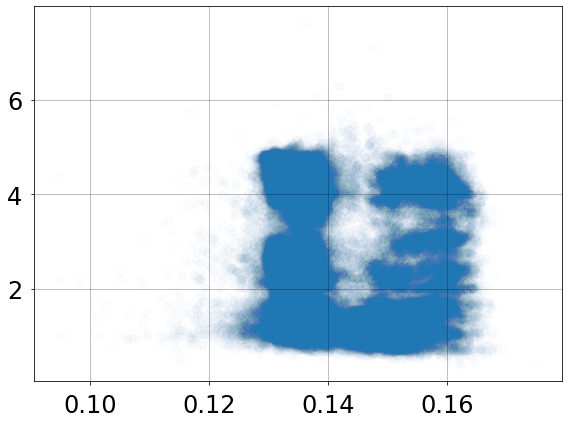

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(filtered_results['COF'], filtered_results['F0'], alpha=0.01)
plt.show()

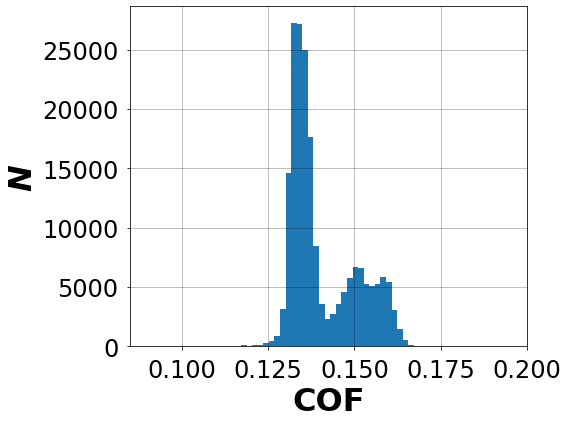

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(filtered_results['COF'], bins=50)
plt.xlabel('COF') 
plt.ylabel('N', style='italic')
plt.xlim(0.085, 0.2)
plt.savefig('./screening_results/plots/COF_dist.pdf', dpi=500)

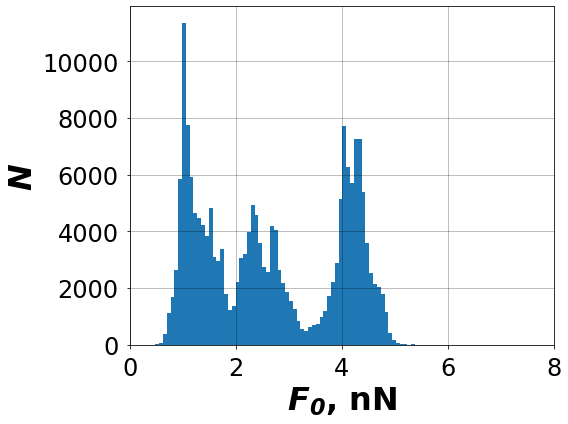

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(filtered_results['F0'], bins=100)
plt.xlabel(r'$\mathbf{F_0}$, nN')
plt.ylabel('N', style='italic')
plt.xlim(0, 8)
plt.savefig('./screening_results/plots/F0_dist.pdf', dpi=500)

# Ranking and Determining Optimal Systems


In [19]:
COF_ranked = filtered_results.sort_values(by="COF").drop(["top_smiles", "top_fracs", "bot_smiles", "bot_fracs"], axis=1)
F0_ranked = filtered_results.sort_values(by="F0").drop(["top_smiles", "top_fracs", "bot_smiles", "bot_fracs"], axis=1)

In [20]:
on = ["top_h_smiles", "top_ch3_smiles", "bot_h_smiles", "bot_ch3_smiles", "COF", "F0", "status"]
n = 2000
optimal = pd.merge(COF_ranked.head(n), F0_ranked.head(n), how="inner", on=on)
optimal = optimal[["top_h_smiles", "top_ch3_smiles", "bot_h_smiles", "bot_ch3_smiles", "COF", "F0", "status"]]

In [21]:
optimal.to_csv("screening_results/plots/optimal.csv")

In [22]:
smiles_set_top = set(optimal['top_h_smiles'])
smiles_set_bot = set(optimal['bot_h_smiles'])
smiles_set = smiles_set_top | smiles_set_bot

In [23]:
smiles_dict = {'C': 'Methane', 
               'C#C': 'Acetylene',
               'C#CC': 'Propyne', 
               'C#N': 'Cyanide', 
               'C#[N+][O-]': 'Fulminic Acid',
               'C1CC1': 'Cyclopropane',
               'C=C': 'Ethylene', 
               'C=C(Cl)Cl': '1,1-Dichloroethene', 
               'C=C(F)F': '1,1-Difluoroethane',
               'C=CC': 'Propene',
               'C=CC#N': 'Acrylonitrile',
               'C=CCl': 'Vinylchloride',
               'CBr': 'Bromoethane', 
               'CC': 'Ethane',
               'CC#CC': 'But-2-yne', 
               'CC#N': 'Acetonitrile', 
               'CC(F)F': 'Difluoroethane', 
               'CCC': 'Propane', 
               'N#CCC#N': 'Malononitrile',
               'N#CCCC#N': '1,2-Dicyanoethane',
               'NC(=O)C(F)F': '2,2-Difluoroacetamide', 
               'O=CNNC=O': '1,2-Diformylhydrazine'}

In [24]:
optimal['top name'] = ''
optimal['bot name'] = ''
for idx, row in optimal.iterrows():
    optimal['top name'][idx] = smiles_dict[row['top_h_smiles']]
    optimal['bot name'][idx] = smiles_dict[row['bot_h_smiles']]

In [25]:
skimmed_optimal = optimal[['top name', 'bot name', 'COF', 'F0']]

In [26]:
for idx, row in skimmed_optimal.iterrows():
    skimmed_optimal['COF'][idx] = round(row['COF'], 4)
    skimmed_optimal['F0'][idx] = round(row['F0'], 4)

/var/folders/h3/60kb27b53ws81h5w0n4s9ppr0000gn/T/ipykernel_79097/1853598775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skimmed_optimal['COF'][idx] = round(row['COF'], 4)
/var/folders/h3/60kb27b53ws81h5w0n4s9ppr0000gn/T/ipykernel_79097/1853598775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skimmed_optimal['F0'][idx] = round(row['F0'], 4)


In [27]:
skimmed_optimal.to_csv("screening_results/plots/skimmed_optimal.csv")